In [ ]:
!pip install aeon
!pip install scikeras

In [ ]:
from aeon.datasets import load_classification
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import random
import torch
import torch.nn as nn

## 1. GunPoint

In [ ]:
X, y, metadata = load_classification(name="GunPoint",return_metadata=True)
y = np.array([int(i)-1 for i in y])
X.shape , y.shape

((200, 1, 150), (200,))

In [ ]:
def load_dataset(PATH):
  loaded_data = np.load(PATH)
  X_train = loaded_data['X_train']
  X_test = loaded_data['X_test']
  y_train = loaded_data['y_train']
  y_test = loaded_data['y_test']
  indices = loaded_data['indices']
  X_train_deq = X_train[indices]
  y_train_deq = y_train[indices]

  return X_train, X_test, X_train_deq, y_train.reshape(y_train.shape[0]), y_test.reshape(y_test.shape[0]), y_train_deq.reshape(y_train_deq.shape[0])

gpds = load_dataset('/content/gunpoint.npz')
gpds[0].shape , gpds[3].shape

((160, 1, 150), (160,))

## 1.1 Preprocessing Data - BALANCED Dataset

### 1.1.1 Splitting Data

In [ ]:
# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train,X_test,y_train,y_test = gpds[0],gpds[1],gpds[3],gpds[4]
X_train.shape, X_test.shape, type(X_train[0][0][0]), type(y_train[0])

((160, 1, 150), (40, 1, 150), numpy.float64, numpy.int64)

### 1.1.2 Normalizing Data

In [ ]:
# normalizing data
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train.reshape(X_train.shape[0],X_train.shape[-1]))
X_test_norm = scaler.transform(X_test.reshape(X_test.shape[0],X_test.shape[-1]))
X_train_norm = X_train_norm.reshape(X_train.shape[0],X_train.shape[-1],1)
X_test_norm = X_test_norm.reshape(X_test.shape[0],X_test.shape[-1],1)
X_train_norm.shape, X_test_norm.shape

((160, 150, 1), (40, 150, 1))

## 1.2 LSTM Model Architecture with 1 layer LSTM

In [ ]:
class LSTM_classifier:
    def __init__(self,input_shape,lstm_units=50,dense_units=100,dropout=0.5,optimizer='adam',binary=True, metrics = ['accuracy']):
        self.model = Sequential()
        self.model.add(LSTM(lstm_units,input_shape=input_shape))
        self.model.add(Dropout(dropout))
        self.model.add(Dense(dense_units,activation='relu'))

        if binary:
            self.model.add(Dense(1,activation='sigmoid'))
            self.model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics= metrics)
        else:
            self.model.add(Dense(1,activation='softmax'))
            self.model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics= metrics)

    def train(self, X_train, y_train,epochs=15, batch_size=32):
        early_stop = EarlyStopping(monitor='val_loss',patience = 15, verbose = 1, restore_best_weights=True)
        checkpoint = ModelCheckpoint('best_model_1_layerLSTM.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        return self.model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,validation_split=0.2,callbacks=[checkpoint,early_stop])

    def evaluate(self,X_test,y_test):
        return self.model.evaluate(X_test,y_test)

    def predict(self,X_test):
        return self.model.predict(X_test)

In [ ]:
# performing cross-validation
timeframes = X_train_norm.shape[1]
features = X_train_norm.shape[-1]

def create_model(input_shape,lstm_units=50,dense_units=100,dropout=0.5,optimizer='adam',binary=True, metrics = ['accuracy']):
        model = Sequential()
        model.add(LSTM(lstm_units,input_shape=input_shape))
        model.add(Dropout(dropout))
        model.add(Dense(dense_units,activation='relu'))

        if binary:
            model.add(Dense(1,activation='sigmoid'))
            model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics= metrics)
        else:
            model.add(Dense(1,activation='softmax'))
            model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics= metrics)
        return model

early_stop = EarlyStopping(monitor='loss',patience = 15, verbose = 1, restore_best_weights=True)

model_lstm1 = KerasClassifier(build_fn=create_model,input_shape=(timeframes,features),epochs=100,optimizer='adam',verbose=1,callbacks=[early_stop])

param_grid = {
    'model__lstm_units': [50,100,200],
    'model__dense_units': [50,100,150],
    'model__dropout': [0.5,0.2],
    'batch_size': [16,32]
}

grid_lstm1 = GridSearchCV(estimator=model_lstm1,param_grid=param_grid,n_jobs=-1,cv=2, verbose=2)

grid_lstm1_result = grid_lstm1.fit(X_train_norm, y_train)
[grid_lstm1_result.best_score_, grid_lstm1_result.best_params_]

Fitting 2 folds for each of 36 candidates, totalling 72 fits


KeyboardInterrupt: 

In [ ]:
timeframes = X_train_norm.shape[1]
features = X_train_norm.shape[-1]

batch_size = 16 #grid_lstm1_result.best_params_['batch_size']
dense_units = 150 #grid_lstm1_result.best_params_['model__dense_units']
dropout = 0.2 #grid_lstm1_result.best_params_['model__dropout']
lstm_units = 100 #grid_lstm1_result.best_params_['model__lstm_units']

LSTM_model = LSTM_classifier(input_shape=(timeframes,features),lstm_units=lstm_units,dense_units=dense_units,dropout=dropout)
history = LSTM_model.train(X_train_norm,y_train,batch_size=batch_size,epochs=100)

Epoch 1/100
8/8 [==============================] - ETA: 0s - loss: 0.6967 - accuracy: 0.5156
Epoch 1: val_loss improved from inf to 0.71727, saving model to best_model_1_layerLSTM.h5
8/8 [==============================] - 4s 180ms/step - loss: 0.6967 - accuracy: 0.5156 - val_loss: 0.7173 - val_accuracy: 0.3750
Epoch 2/100
2/8 [======>.......................] - ETA: 0s - loss: 0.6902 - accuracy: 0.5625

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - ETA: 0s - loss: 0.6853 - accuracy: 0.5703
Epoch 2: val_loss improved from 0.71727 to 0.69293, saving model to best_model_1_layerLSTM.h5
8/8 [==============================] - 1s 79ms/step - loss: 0.6853 - accuracy: 0.5703 - val_loss: 0.6929 - val_accuracy: 0.3750
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.6839 - accuracy: 0.5703
Epoch 3: val_loss did not improve from 0.69293
8/8 [==============================] - 1s 81ms/step - loss: 0.6839 - accuracy: 0.5703 - val_loss: 0.7010 - val_accuracy: 0.4062
Epoch 4/100
8/8 [==============================] - ETA: 0s - loss: 0.6720 - accuracy: 0.5703
Epoch 4: val_loss improved from 0.69293 to 0.65940, saving model to best_model_1_layerLSTM.h5
8/8 [==============================] - 1s 131ms/step - loss: 0.6720 - accuracy: 0.5703 - val_loss: 0.6594 - val_accuracy: 0.5312
Epoch 5/100
8/8 [==============================] - ETA: 0s - loss: 0.6411 - accuracy: 0.6562
Epoch 5: val_loss im

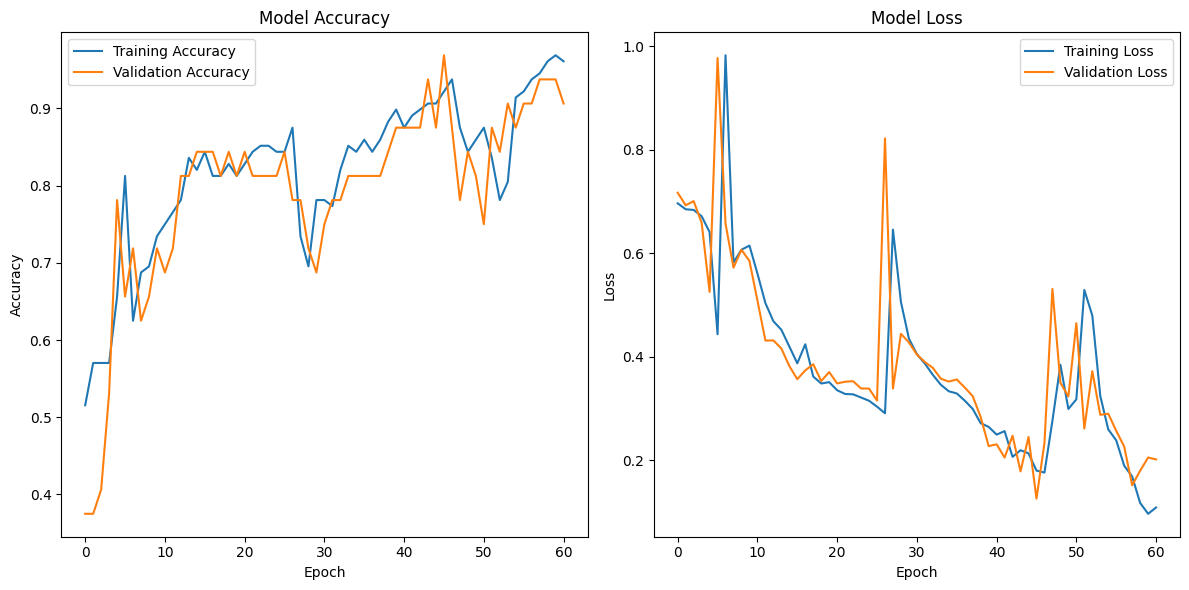

In [ ]:
# Plotting training & validation accuracy
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plotting training & validation loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()  # Adjusts the plots to prevent overlap
plt.show()

In [ ]:
model = load_model('best_model_1_layerLSTM.h5')
loss, accuracy = model.evaluate(X_test_norm, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Errors = {round(len(y_test) - len(y_test)*accuracy)}")

2/2 [==============================] - 1s 28ms/step - loss: 0.2584 - accuracy: 0.9250
Test Accuracy: 92.50%
Errors = 3


## 1.3 Other LSTM architechture - 2 layers LSTM instead of just one

In [ ]:
def build_model(input_shape,lstm_units=50,dropout=0.2):
    model = Sequential()
    model.add(LSTM(lstm_units, activation='tanh', recurrent_activation='sigmoid', input_shape=input_shape, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(lstm_units, activation='tanh', recurrent_activation='sigmoid'))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create a ModelCheckpoint callback and Early stop
early_stop = EarlyStopping(monitor='val_loss',patience = 5, verbose = 1, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
### ---------- CROSS-VALIDATION ------------ ###

model_lstm2 = KerasClassifier(build_fn=build_model,input_shape=(timeframes,features),epochs=100,optimizer='adam',verbose=1,callbacks=[early_stop])

param_grid = {
    'model__lstm_units': [50,100,200],
    'model__dropout': [0.5,0.2],
    'batch_size': [16,32]
}

grid_lstm2 = GridSearchCV(estimator=model_lstm2,param_grid=param_grid,n_jobs=-1,cv=2, verbose=5)

grid_lstm2_result = grid_lstm2.fit(X_train_norm, y_train)
[grid_lstm1_result.best_score_, grid_lstm1_result.best_params_]

In [ ]:
batch_size = 16 #grid_lstm1_result.best_params_['batch_size']
dropout = 0.2 #grid_lstm1_result.best_params_['model__dropout']
lstm_units = 100 #grid_lstm1_result.best_params_['model__lstm_units']

model = build_model((X_train_norm.shape[1], 1),lstm_units,dropout)
history = model.fit(X_train_norm, y_train, epochs=100, batch_size=batch_size, validation_split=0.2,callbacks=[checkpoint,early_stop])

Epoch 1/100
8/8 [==============================] - ETA: 0s - loss: 0.6911 - accuracy: 0.5391
Epoch 1: val_loss did not improve from 0.08110
8/8 [==============================] - 8s 464ms/step - loss: 0.6911 - accuracy: 0.5391 - val_loss: 0.7199 - val_accuracy: 0.4062
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 0.6694 - accuracy: 0.5781
Epoch 2: val_loss did not improve from 0.08110
8/8 [==============================] - 1s 180ms/step - loss: 0.6694 - accuracy: 0.5781 - val_loss: 0.6590 - val_accuracy: 0.4375
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.6405 - accuracy: 0.6328
Epoch 3: val_loss did not improve from 0.08110
8/8 [==============================] - 1s 172ms/step - loss: 0.6405 - accuracy: 0.6328 - val_loss: 0.5245 - val_accuracy: 0.7812
Epoch 4/100
8/8 [==============================] - ETA: 0s - loss: 0.5303 - accuracy: 0.7891
Epoch 4: val_loss did not improve from 0.08110
8/8 [==============================] - 1s 183ms/step 

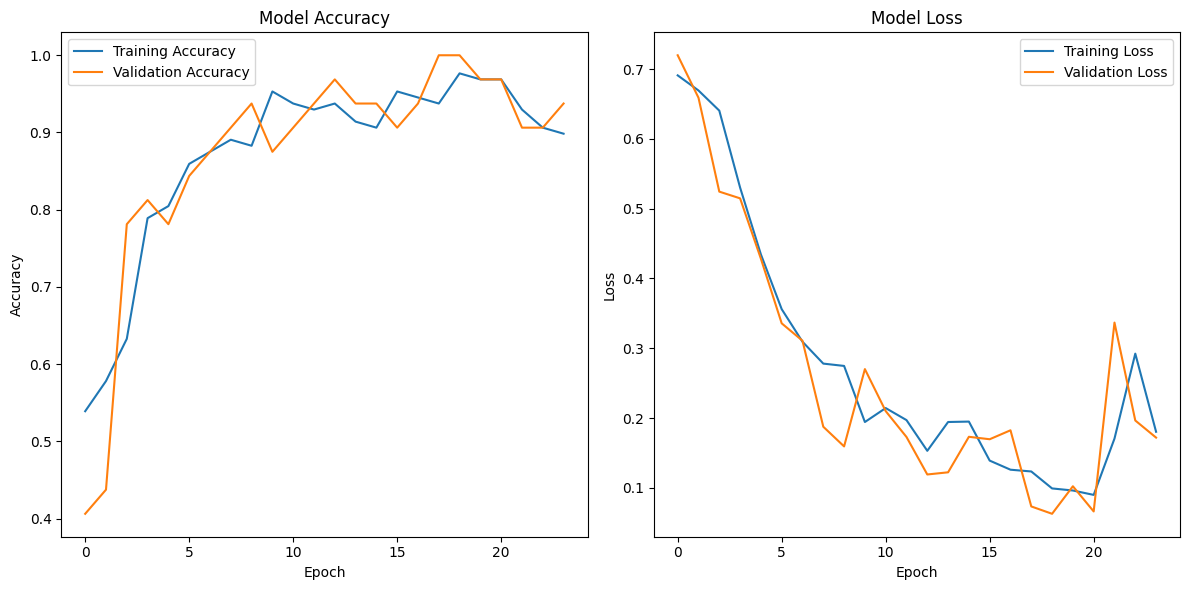

In [ ]:
# Plotting training & validation accuracy
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plotting training & validation loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()  # Adjusts the plots to prevent overlap
plt.show()


In [ ]:
model = load_model('best_model.h5')
loss, accuracy = model.evaluate(X_test_norm, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Errors = {round(len(y_test) - len(y_test)*accuracy)}")

2/2 [==============================] - 2s 44ms/step - loss: 0.1301 - accuracy: 0.9500
Test Accuracy: 95.00%
Errors = 2


## 1.4 Pytorch LSTM (same 2 layers architechture)

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout=0.2):
        super(LSTMClassifier, self).__init__()

        # First LSTM layer with dropout
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, batch_first=True,)
        self.dropout1 = nn.Dropout(dropout)

        # Second LSTM layer with dropout
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.dropout2 = nn.Dropout(dropout)

        # Second LSTM layer with dropout
        self.lstm3 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.dropout3 = nn.Dropout(dropout)

        # Final dense layer for binary classification
        self.dense = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # Passing data through the first LSTM layer
        x, _ = self.lstm1(x)
        x = self.dropout1(x)

        # Passing data through the second LSTM layer
        x, _ = self.lstm2(x)
        x = self.dropout2(x)

        x, _ = self.lstm3(x)
        x = self.dropout3(x)

        # Only take the output from the last time step
        x = x[:, -1, :]

        # Passing through the dense layer
        x = self.dense(x)
        return x


In [ ]:
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# normalizing data
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train.reshape(X_train.shape[0],X_train.shape[-1]))
X_val_norm = scaler.transform(X_val.reshape(X_val.shape[0],X_val.shape[-1]))
X_test_norm = scaler.transform(X_test.reshape(X_test.shape[0],X_test.shape[-1]))
X_train_norm = X_train_norm.reshape(X_train.shape[0],X_train.shape[-1],1)
X_val_norm = X_val_norm.reshape(X_val.shape[0],X_val.shape[-1],1)
X_test_norm = X_test_norm.reshape(X_test.shape[0],X_test.shape[-1],1)
X_train_norm.shape,X_val_norm.shape ,X_test_norm.shape, y_train.shape

# loading dataloader
train_dataset = TimeSeriesDataset(X_train_norm, y_train)
val_dataset = TimeSeriesDataset(X_val_norm, y_val)
test_dataset = TimeSeriesDataset(X_test_norm, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
X_train, y_train

(array([[[-0.65478424, -0.65491143, -0.65408087, ..., -0.78535042,
          -0.78400886, -0.78142327]],
 
        [[-1.4143145 , -1.4153755 , -1.4162683 , ..., -1.4536583 ,
          -1.4567444 , -1.454602  ]],
 
        [[-0.75673011, -0.75511952, -0.75222982, ..., -0.70379   ,
          -0.69131035, -0.68106536]],
 
        ...,
 
        [[-0.65786191, -0.65630813, -0.65633997, ..., -0.62331433,
          -0.62371383, -0.62418686]],
 
        [[-0.75331069, -0.75462117, -0.75366734, ..., -0.72890649,
          -0.72926506, -0.7290889 ]],
 
        [[-0.9662877 , -0.97152532, -0.97188058, ..., -1.008073  ,
          -1.009745  , -1.0062835 ]]]),
 array([1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 

In [ ]:
def save_checkpoint(model, filename="best_model_pytorch.pth"):
    torch.save(model.state_dict(), filename)

def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=100,early_stop=10):
    best_val_loss = float('inf')
    history = {'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}

    for epoch in range(epochs):
        model.train()
        total_train_loss, total_train_accuracy = 0, 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.unsqueeze(1))
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            predictions = torch.sigmoid(outputs).round()
            total_train_accuracy += (predictions.squeeze(1) == y_batch).sum().item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_accuracy = total_train_accuracy / len(train_loader.dataset)

        # Validation
        # if epoch%5 == 0:
        model.eval()
        total_val_loss, total_val_accuracy = 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch.unsqueeze(1))
                total_val_loss += loss.item()
                predictions = torch.sigmoid(outputs).round()
                total_val_accuracy += (predictions.squeeze(1) == y_batch).sum().item()

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_accuracy = total_val_accuracy / len(val_loader.dataset)

        print(f'Epoch {epoch + 1}/{epochs}, '
              f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}, '
              f'Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}')

        # Checkpoint
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            save_checkpoint(model, "best_model.pth")
        else:
            epochs_no_improve+=1
            if epochs_no_improve >= early_stop:
              print(f"Early stop triggered at epoch {epoch} !!!")
              break

        history['train_loss'].append(avg_train_loss)
        history['train_accuracy'].append(avg_train_accuracy)
        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(avg_val_accuracy)

    return history

In [ ]:
torch.manual_seed(43)
input_dim = 1
hidden_dim = 100
model = LSTMClassifier(input_dim, hidden_dim)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
history = train_model(model, criterion, optimizer, train_loader,val_loader ,epochs=150)

Epoch 1/150, Train Loss: 0.6959, Train Accuracy: 0.4062, Val Loss: 0.6925, Val Accuracy: 0.5625
Epoch 2/150, Train Loss: 0.6933, Train Accuracy: 0.5156, Val Loss: 0.6936, Val Accuracy: 0.4375
Epoch 3/150, Train Loss: 0.6920, Train Accuracy: 0.5547, Val Loss: 0.6942, Val Accuracy: 0.4375
Epoch 4/150, Train Loss: 0.6919, Train Accuracy: 0.5156, Val Loss: 0.6949, Val Accuracy: 0.4375
Epoch 5/150, Train Loss: 0.6893, Train Accuracy: 0.5234, Val Loss: 0.6807, Val Accuracy: 0.6250
Epoch 6/150, Train Loss: 0.6628, Train Accuracy: 0.6484, Val Loss: 0.6232, Val Accuracy: 0.6562
Epoch 7/150, Train Loss: 0.5249, Train Accuracy: 0.7969, Val Loss: 0.4390, Val Accuracy: 0.7812
Epoch 8/150, Train Loss: 0.5004, Train Accuracy: 0.7812, Val Loss: 0.7043, Val Accuracy: 0.7500
Epoch 9/150, Train Loss: 0.6992, Train Accuracy: 0.6875, Val Loss: 0.6288, Val Accuracy: 0.7188
Epoch 10/150, Train Loss: 0.5746, Train Accuracy: 0.7188, Val Loss: 0.5525, Val Accuracy: 0.7812
Epoch 11/150, Train Loss: 0.4923, Train

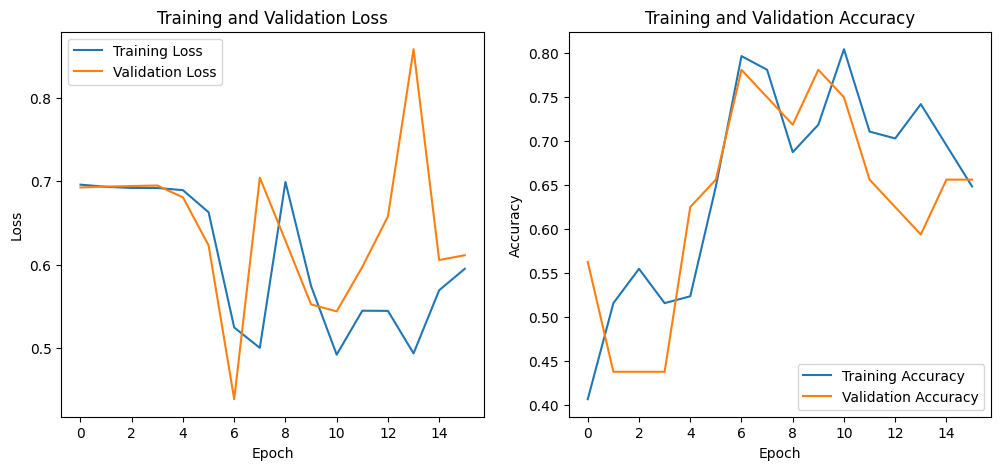

In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
model.load_state_dict(torch.load('best_model.pth'))
def evaluate_model(model, test_loader):
    model.eval()
    total_loss, total_accuracy = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.unsqueeze(1))
            total_loss += loss.item()
            predictions = torch.sigmoid(outputs).round()
            total_accuracy += (predictions.squeeze(1) == y_batch).sum().item()
    avg_loss = total_loss / len(test_loader)
    avg_accuracy = total_accuracy / len(test_loader.dataset)
    return avg_loss, avg_accuracy

# Assuming test_loader is a DataLoader object for your test data
test_loss, test_accuracy = evaluate_model(model, test_loader)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')
print(f'Errors = {int(len(y_test) - len(y_test)*test_accuracy)}')

Test Loss: 0.4014742225408554, Test Accuracy: 0.825
Errors = 7


## 1.5 Preprocessing Data - UNBALANCED Dataset

### 1.5.1 Unbalancing Dataset

In [ ]:
def make_dataset_imbalanced(X, y, class_to_reduce=0, reduction_factor=0.1):
    """
    Reduces the number of samples in the specified class by the reduction factor.

    Parameters:
    X (np.array): Feature data.
    y (np.array): Labels.
    class_to_reduce (int): The class whose samples are to be reduced.
    reduction_factor (float): The fraction of the class_to_reduce samples to keep (0 < reduction_factor <= 1).

    Returns:
    (np.array, np.array): The imbalanced features and labels.
    """
    # Indices of the class to reduce and the other class
    reduce_indices = np.where(y == class_to_reduce)[0]
    other_indices = np.where(y != class_to_reduce)[0]

    # Randomly select a subset of the class to reduce
    reduced_indices = np.random.choice(reduce_indices, int(len(reduce_indices) * reduction_factor), replace=False)

    # Combine the reduced class indices with the other class indices
    new_indices = np.concatenate([reduced_indices, other_indices])
    np.random.shuffle(new_indices)  # Shuffle the indices to mix the classes

    # Create the new imbalanced dataset
    X_imbalanced = X[new_indices]
    y_imbalanced = y[new_indices]

    return X_imbalanced, y_imbalanced

In [ ]:
# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
# X_train_reduced, y_train_reduced = make_dataset_imbalanced(X_train, y_train, class_to_reduce=1, reduction_factor=0.1)
X_train_reduced, y_train_reduced = gpds[2], gpds[-1]
X_train_reduced.shape, y_train_reduced.shape

((88, 1, 150), (88,))

In [ ]:
y_train_reduced, y_train_reduced.sum()

(array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1]),
 80)

### 1.5.2 Normalizing Data

In [ ]:
X_train_reduced_norm = scaler.fit_transform(X_train_reduced.reshape(X_train_reduced.shape[0],X_train_reduced.shape[-1]))
X_test_norm = scaler.transform(X_test.reshape(X_test.shape[0],X_test.shape[-1]))
X_train_reduced_norm = X_train_reduced_norm.reshape(X_train_reduced_norm.shape[0],X_train_reduced_norm.shape[-1],1)
X_test_norm = X_test_norm.reshape(X_test.shape[0],X_test.shape[-1],1)
X_train_reduced_norm.shape, X_test_norm.shape

((88, 150, 1), (40, 150, 1))

In [ ]:
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(100, activation='tanh', recurrent_activation='sigmoid', input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100, activation='tanh', recurrent_activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

unbalanced_model = build_model((X_train_reduced_norm.shape[1], 1))

# Create a ModelCheckpoint callback and Early stop
early_stop = EarlyStopping(monitor='val_loss',patience = 10, verbose = 1, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model_unbalanced.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history_unb = unbalanced_model.fit(X_train_reduced_norm, y_train_reduced, epochs=100, batch_size=16, validation_split=0.2,callbacks=[checkpoint,early_stop])

Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.6685 - accuracy: 0.6000
Epoch 1: val_loss improved from inf to 0.62970, saving model to best_model_unbalanced.h5
5/5 [==============================] - 10s 710ms/step - loss: 0.6685 - accuracy: 0.6000 - val_loss: 0.6297 - val_accuracy: 0.7778
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.5107 - accuracy: 0.9429
Epoch 2: val_loss improved from 0.62970 to 0.47732, saving model to best_model_unbalanced.h5
5/5 [==============================] - 1s 233ms/step - loss: 0.5107 - accuracy: 0.9429 - val_loss: 0.4773 - val_accuracy: 0.7778
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.2465 - accuracy: 0.9429
Epoch 3: val_loss did not improve from 0.47732
5/5 [==============================] - 2s 391ms/step - loss: 0.2465 - accuracy: 0.9429 - val_loss: 0.8544 - val_accuracy: 0.7778
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.2424 - accuracy: 0.9429
Epoch 4: va

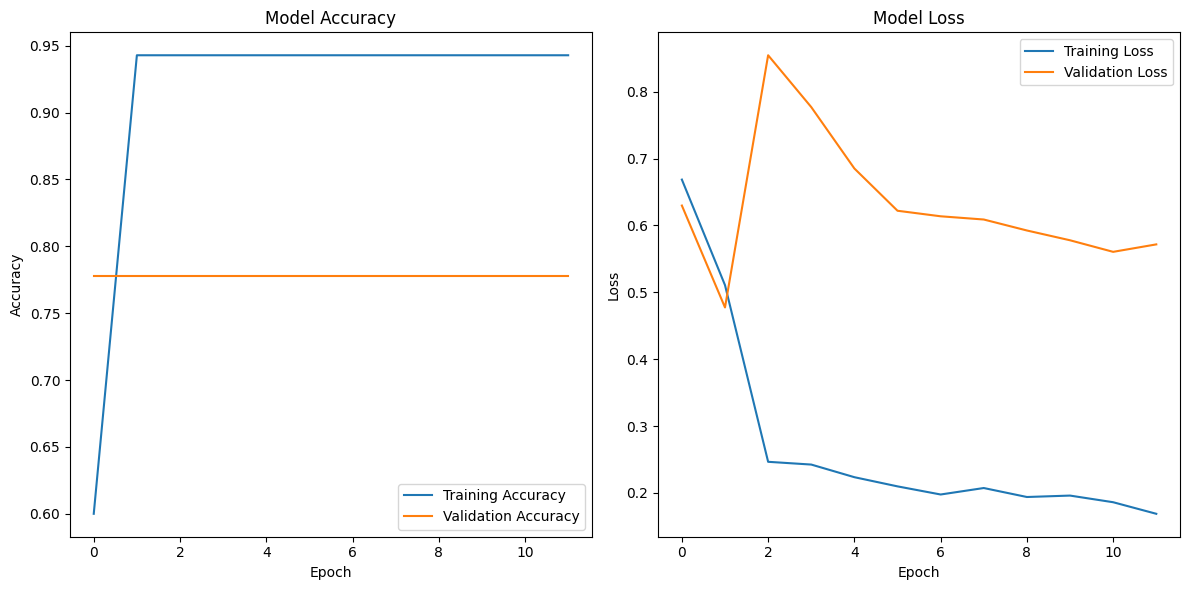

In [ ]:
# Plotting training & validation accuracy
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(history_unb.history['accuracy'], label='Training Accuracy')
plt.plot(history_unb.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plotting training & validation loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(history_unb.history['loss'], label='Training Loss')
plt.plot(history_unb.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()  # Adjusts the plots to prevent overlap
plt.show()

In [ ]:
model_unbalanced = load_model('best_model_unbalanced.h5')
loss, accuracy = model_unbalanced.evaluate(X_test_norm, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Errors = {round(len(y_test) - len(y_test)*accuracy)}")

2/2 [==============================] - 1s 50ms/step - loss: 0.7912 - accuracy: 0.5000
Test Accuracy: 50.00%
Errors = 20


## 1.6 Applying Class Weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Convert class_weights to a dictionary to pass it to Keras
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 0.9696969696969697, 1: 1.032258064516129}

In [ ]:
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(100, activation='tanh', recurrent_activation='sigmoid', input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100, activation='tanh', recurrent_activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

unbalanced_model = build_model((X_train_reduced_norm.shape[1], 1))

# Create a ModelCheckpoint callback and Early stop
early_stop = EarlyStopping(monitor='val_loss',patience = 10, verbose = 1, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model_unbalanced.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history_unb = unbalanced_model.fit(X_train_reduced_norm, y_train_reduced, epochs=100, batch_size=16, validation_split=0.2,callbacks=[checkpoint,early_stop],class_weight=class_weights_dict)

Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.6758 - accuracy: 0.6857
Epoch 1: val_loss improved from inf to 0.61703, saving model to best_model_unbalanced.h5
5/5 [==============================] - 11s 1s/step - loss: 0.6758 - accuracy: 0.6857 - val_loss: 0.6170 - val_accuracy: 0.7778
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - ETA: 0s - loss: 0.4823 - accuracy: 0.9429
Epoch 2: val_loss improved from 0.61703 to 0.48893, saving model to best_model_unbalanced.h5
5/5 [==============================] - 2s 403ms/step - loss: 0.4823 - accuracy: 0.9429 - val_loss: 0.4889 - val_accuracy: 0.7778
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.2347 - accuracy: 0.9429
Epoch 3: val_loss did not improve from 0.48893
5/5 [==============================] - 2s 402ms/step - loss: 0.2347 - accuracy: 0.9429 - val_loss: 0.9367 - val_accuracy: 0.7778
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.2317 - accuracy: 0.9429
Epoch 4: val_loss did not improve from 0.48893
5/5 [==============================] - 2s 418ms/step - loss: 0.2317 - accuracy: 0.9429 - val_loss: 0.8051 - val_accuracy: 0.7778
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.2141 - accuracy: 0.9429
Epoch 5: val_loss did not improve from 0.48893
5/5 [==============

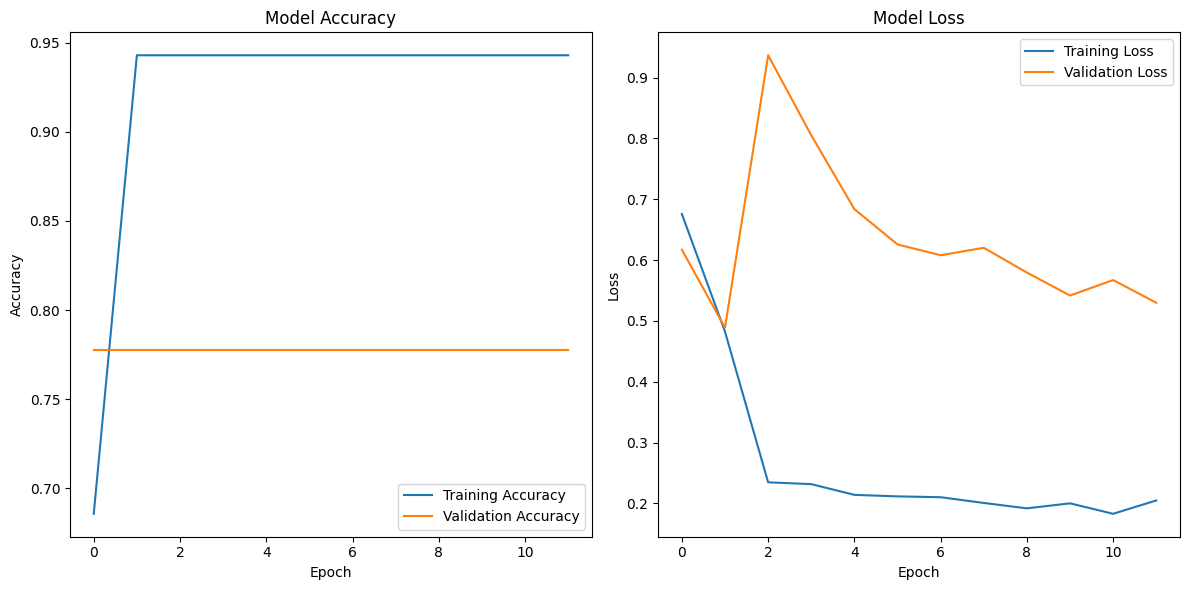

In [ ]:
# Plotting training & validation accuracy
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(history_unb.history['accuracy'], label='Training Accuracy')
plt.plot(history_unb.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plotting training & validation loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(history_unb.history['loss'], label='Training Loss')
plt.plot(history_unb.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()  # Adjusts the plots to prevent overlap
plt.show()

In [ ]:
model_unbalanced = load_model('best_model_unbalanced.h5')
loss, accuracy = model_unbalanced.evaluate(X_test_norm, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Errors = {round(len(y_test) - len(y_test)*accuracy)}")

2/2 [==============================] - 2s 66ms/step - loss: 0.9870 - accuracy: 0.5000
Test Accuracy: 50.00%
Errors = 20


## 1.7 Applying SMOTE

In [ ]:
# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
# X_train_reduced, y_train_reduced = make_dataset_imbalanced(X_train, y_train, class_to_reduce=1, reduction_factor=0.1)
X_train_reduced, y_train_reduced = gpds[2], gpds[-1]
X_train_reduced.shape, y_train_reduced.shape

from imblearn.over_sampling import SMOTE

# Apply SMOTE
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_reduced.reshape(X_train_reduced.shape[0],X_train_reduced.shape[-1]), y_train_reduced)

X_train_smote_norm = scaler.fit_transform(X_train_smote)
X_test_norm = scaler.transform(X_test.reshape(X_test.shape[0],X_test.shape[-1]))
X_train_smote_norm = X_train_smote_norm.reshape(X_train_smote_norm.shape[0],X_train_smote_norm.shape[-1],1)
X_test_norm = X_test_norm.reshape(X_test.shape[0],X_test.shape[-1],1)
print(X_train_smote_norm.shape, X_test_norm.shape)
y_train_smote.sum() ## data is again BALANCED

(160, 150, 1) (40, 150, 1)


80

In [ ]:
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(100, activation='tanh', recurrent_activation='sigmoid', input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100, activation='tanh', recurrent_activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

smote_model = build_model((X_train_smote_norm.shape[1], 1))

# Create a ModelCheckpoint callback and Early stop
early_stop = EarlyStopping(monitor='val_loss',patience = 20, verbose = 1, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model_smote.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history_smote = smote_model.fit(X_train_smote_norm, y_train_smote, epochs=100, batch_size=16, validation_split=0.2,callbacks=[checkpoint,early_stop])

Epoch 1/100
8/8 [==============================] - ETA: 0s - loss: 0.6677 - accuracy: 0.5391
Epoch 1: val_loss improved from inf to 0.76833, saving model to best_model_smote.h5
8/8 [==============================] - 8s 328ms/step - loss: 0.6677 - accuracy: 0.5391 - val_loss: 0.7683 - val_accuracy: 0.3438
Epoch 2/100
1/8 [==>...........................] - ETA: 0s - loss: 0.5836 - accuracy: 0.3750

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - ETA: 0s - loss: 0.5873 - accuracy: 0.5156
Epoch 2: val_loss did not improve from 0.76833
8/8 [==============================] - 1s 180ms/step - loss: 0.5873 - accuracy: 0.5156 - val_loss: 0.9956 - val_accuracy: 0.0000e+00
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.5198 - accuracy: 0.6250
Epoch 3: val_loss did not improve from 0.76833
8/8 [==============================] - 1s 172ms/step - loss: 0.5198 - accuracy: 0.6250 - val_loss: 0.8735 - val_accuracy: 0.0938
Epoch 4/100
8/8 [==============================] - ETA: 0s - loss: 0.4773 - accuracy: 0.7031
Epoch 4: val_loss improved from 0.76833 to 0.69617, saving model to best_model_smote.h5
8/8 [==============================] - 1s 180ms/step - loss: 0.4773 - accuracy: 0.7031 - val_loss: 0.6962 - val_accuracy: 0.6875
Epoch 5/100
8/8 [==============================] - ETA: 0s - loss: 0.4472 - accuracy: 0.7578
Epoch 5: val_loss improved from 0.69617 to 0.56429, saving model to

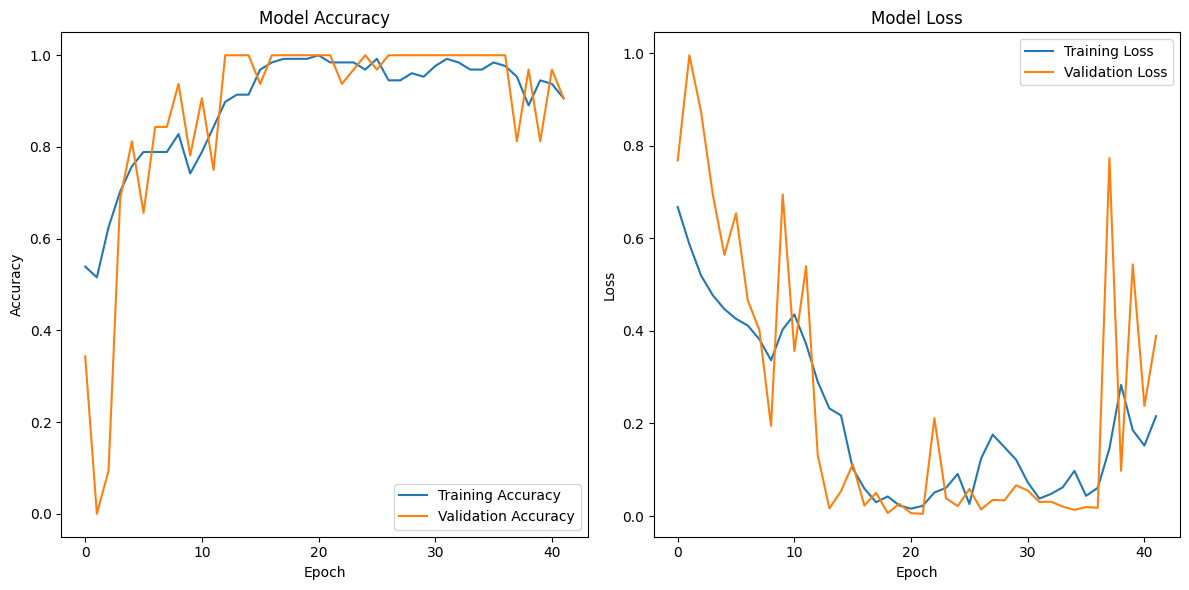

In [ ]:
# Plotting training & validation accuracy
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(history_smote.history['accuracy'], label='Training Accuracy')
plt.plot(history_smote.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plotting training & validation loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(history_smote.history['loss'], label='Training Loss')
plt.plot(history_smote.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()  # Adjusts the plots to prevent overlap
plt.show()

In [ ]:
model_smote = load_model('best_model_smote.h5')
loss, accuracy = model_smote.evaluate(X_test_norm, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Errors = {round(len(y_test) - len(y_test)*accuracy)}")

2/2 [==============================] - 1s 40ms/step - loss: 0.5015 - accuracy: 0.8500
Test Accuracy: 85.00%
Errors = 6
